In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [87]:
df = pd.read_csv("../data/df_final.csv")
df['v2x_polyarchy_diff'] = abs(df['v2x_polyarchy_o'] - df['v2x_polyarchy_d'])
df['v2x_libdem_diff'] = abs(df['v2x_libdem_o'] - df['v2x_libdem_d'])
df['v2x_partipdem_diff'] = abs(df['v2x_partipdem_o'] - df['v2x_partipdem_d'])
df['v2x_delibdem_diff'] = abs(df['v2x_delibdem_o'] - df['v2x_delibdem_d'])
df['v2x_egaldem_diff'] = abs(df['v2x_egaldem_o'] - df['v2x_egaldem_d'])
df_final = df.drop(columns=[
    'v2x_polyarchy_o', 'v2x_polyarchy_d',
    'v2x_libdem_o', 'v2x_libdem_d',
    'v2x_partipdem_o', 'v2x_partipdem_d',
    'v2x_delibdem_o', 'v2x_delibdem_d',
    'v2x_egaldem_o', 'v2x_egaldem_d'])

In [88]:
# Define two groups of geopolitical distance based on domain knowledge & assumptions
# Measures in the positive group should reduce geopolitical distance, while in the negative group, they should increase it.
group_positive = ['comlang_off', 'comlang_ethno', 'comrelig', 'fta_wto', 'arms']
group_negative = ['IdealPointDistance', 'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff', 'v2x_egaldem_diff']

df_final[group_negative] = -df_final[group_negative] # Negative sign because of above-mentioned

geo_vars = group_positive + group_negative

In [89]:
# Standardizing
scaler = StandardScaler()
df_final[geo_vars] = scaler.fit_transform(df_final[geo_vars])

### Factor Analysis

In [90]:
fa_all = FactorAnalysis(n_components=1, random_state=222)
factor_scores_all = fa_all.fit_transform(df_final[geo_vars])

df_final['geopolitical_closeness_index_fa'] = factor_scores_all[:, 0]

In [91]:
communalities = np.square(fa_loadings).flatten()

fa_importance_df = pd.DataFrame({
    "Variable": geo_vars,
    "Loading": fa_loadings.flatten(),
    "Communality": communalities
})

fa_importance_df['abs_loading'] = fa_importance_df['Loading'].abs()
fa_importance_df.sort_values(by='abs_loading', ascending=False, inplace=True)
fa_importance_df.drop(columns='abs_loading', inplace=True)

print("Factor Analysis Variable Importances:")
print(fa_importance_df)

Factor Analysis Variable Importances:
              Variable   Loading  Communality
7      v2x_libdem_diff -0.987460     0.975078
9    v2x_delibdem_diff -0.958330     0.918396
6   v2x_polyarchy_diff -0.938136     0.880099
10    v2x_egaldem_diff -0.905726     0.820340
8   v2x_partipdem_diff -0.742575     0.551418
5   IdealPointDistance -0.504967     0.254992
2             comrelig -0.262537     0.068926
4                 arms  0.243359     0.059223
3              fta_wto  0.137748     0.018975
0          comlang_off  0.024341     0.000592
1        comlang_ethno  0.002594     0.000007


In [92]:
# Re-standardize geopolitical distance
scaler_comp = StandardScaler()
df_final['geopolitical_closeness_index_fa'] = scaler_comp.fit_transform(df_final[['geopolitical_closeness_index_fa']])

### Principal Component Analysis

In [93]:
pca_full = PCA(n_components=len(geo_vars), random_state=222)
pca_full.fit(df_final[geo_vars])

PCA(n_components=11, random_state=222)

In [94]:
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components_needed = np.argmax(cumulative_variance >= 0.80) + 1  # First index where cumulative variance >= 80%

print("Explained Variance Ratio (all components):", explained_variance)
print("Cumulative Variance:", cumulative_variance)
print("Number of components needed to explain at least 80% variance:", n_components_needed)

Explained Variance Ratio (all components): [0.43653975 0.17701917 0.09703395 0.08927586 0.08374557 0.04655347
 0.03322317 0.01358485 0.01148106 0.00760464 0.00393851]
Cumulative Variance: [0.43653975 0.61355892 0.71059287 0.79986873 0.8836143  0.93016777
 0.96339094 0.9769758  0.98845685 0.99606149 1.        ]
Number of components needed to explain at least 80% variance: 5


In [95]:
pca_refined = PCA(n_components=n_components_needed, random_state=222)
geo_scores = pca_refined.fit_transform(df_final[geo_vars])

In [96]:
component_loadings = pca_refined.components_
component_weights = np.abs(component_loadings).sum(axis=0)
normalized_weights = component_weights / component_weights.sum()

weights_df = pd.DataFrame({
    "Variable": geo_vars,
    "PCA_Weight": normalized_weights
})

weights_df.sort_values(by="PCA_Weight", ascending=False, inplace=True)
print("\nVariable Weights Derived from PCA:")
print(weights_df)


Variable Weights Derived from PCA:
              Variable  PCA_Weight
3              fta_wto    0.131255
4                 arms    0.128669
2             comrelig    0.128065
1        comlang_ethno    0.092047
0          comlang_off    0.091647
5   IdealPointDistance    0.080261
10    v2x_egaldem_diff    0.076544
9    v2x_delibdem_diff    0.070070
6   v2x_polyarchy_diff    0.068246
7      v2x_libdem_diff    0.066842
8   v2x_partipdem_diff    0.066354


In [97]:
df_final["geopolitical_closeness_index_pca"] = np.dot(df_final[geo_vars], normalized_weights)

scaler_pca = StandardScaler()
df_final['geopolitical_closeness_index_pca'] = scaler_pca.fit_transform(df_final[['geopolitical_closeness_index_pca']])

In [98]:
df_subset = df_final[df_final['logallexports'].notnull()].copy()

pls = PLSRegression(n_components=1)
pls.fit(df_subset[geo_vars], df_subset['logallexports'])
df_subset['geopolitical_closeness_index_pls'] = pls.transform(df_subset[geo_vars])

### Comparison

#### 1. Using correlation with trade values
##### Generally, due to how we've defined our metric, we expect positive correlation with trade indicators
##### For the metric obtained from factor analysis, it is true, but for the metric from PCA, it is negative and small in magnitude

In [99]:
# Using correlation with trade values
export_vars = [
    'logallexports', 'logchemicalexports', 'logconsumerexports', 
    'logfoodexports', 'logmachineryexports', 'logmanufacturesexports', 'logtradeflow'
]

correlations = {}
for var in export_vars:
    correlations[var] = {
         "PCA_Composite": df_final['geopolitical_closeness_index_pca'].corr(df_final[var]),
         "FA_Composite": df_final['geopolitical_closeness_index_fa'].corr(df_final[var]),
        "PLS_Composite": df_subset['geopolitical_closeness_index_pls'].corr(df_subset[var]),
    }
    
corr_df = pd.DataFrame(correlations).T
print("Correlation of Composite Metrics with Export Variables:")
print(corr_df)

Correlation of Composite Metrics with Export Variables:
                        PCA_Composite  FA_Composite  PLS_Composite
logallexports               -0.054102      0.369670       0.508761
logchemicalexports           0.027494      0.277658       0.414972
logconsumerexports           0.031647      0.276886       0.415572
logfoodexports               0.124480      0.183494       0.325197
logmachineryexports         -0.085893      0.373451       0.500501
logmanufacturesexports      -0.071996      0.371841       0.503576
logtradeflow                -0.086073      0.345481       0.510975


#### 2. Using scatterplot with trade value
##### Both do not have clear relationship with logallexports, but we can see at least an upward trend with FA Composite

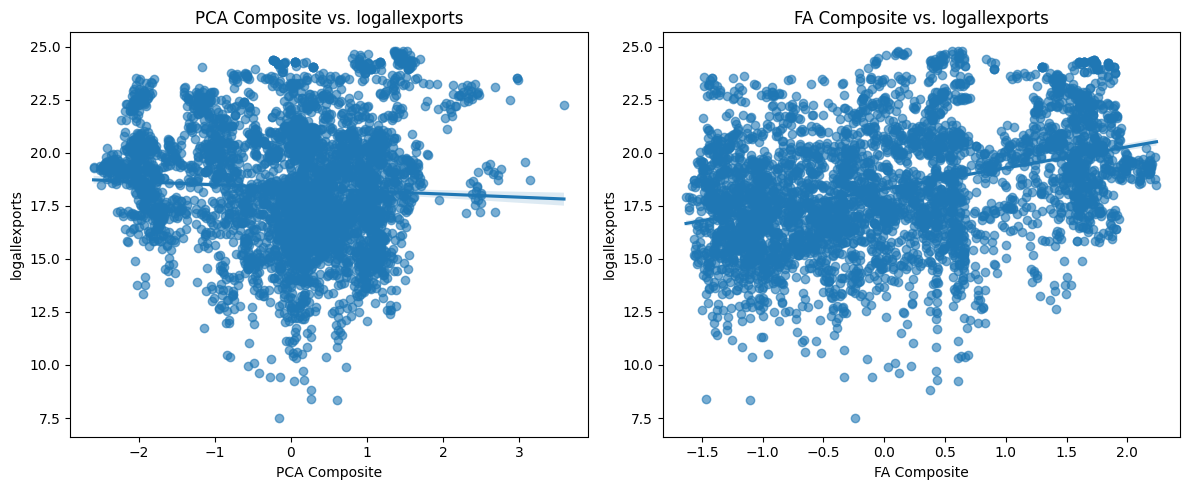

In [100]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x=df_final['geopolitical_closeness_index_pca'], y=df_final['logallexports'], scatter_kws={'alpha':0.6})
plt.title("PCA Composite vs. logallexports")
plt.xlabel("PCA Composite")
plt.ylabel("logallexports")

plt.subplot(1, 2, 2)
sns.regplot(x=df_final['geopolitical_closeness_index_fa'], y=df_final['logallexports'], scatter_kws={'alpha':0.6})
plt.title("FA Composite vs. logallexports")
plt.xlabel("FA Composite")
plt.ylabel("logallexports")

plt.tight_layout()
plt.show()

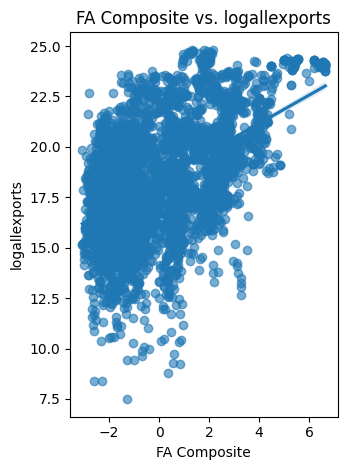

In [101]:
plt.subplot(1, 2, 2)
sns.regplot(x=df_subset['geopolitical_closeness_index_pls'], y=df_subset['logallexports'], scatter_kws={'alpha':0.6})
plt.title("FA Composite vs. logallexports")
plt.xlabel("FA Composite")
plt.ylabel("logallexports")

plt.tight_layout()
plt.show()

#### 3. Using linear regression
##### Same as above

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_pca = df_subset[['geopolitical_closeness_index_pca']]
y = df_subset['logallexports']
model_pca = LinearRegression().fit(X_pca, y)
y_pred_pca = model_pca.predict(X_pca)
rmse_pca = np.sqrt(mean_squared_error(y, y_pred_pca))
r2_pca = r2_score(y, y_pred_pca)

# Model with FA composite
X_fa = df_subset[['geopolitical_closeness_index_fa']]
model_fa = LinearRegression().fit(X_fa, y)
y_pred_fa = model_fa.predict(X_fa)
rmse_fa = np.sqrt(mean_squared_error(y, y_pred_fa))
r2_fa = r2_score(y, y_pred_fa)

print("Model using PCA composite:")
print("RMSE:", rmse_pca, "R²:", r2_pca)
print("\nModel using FA composite:")
print("RMSE:", rmse_fa, "R²:", r2_fa)

Model using PCA composite:
RMSE: 2.805764844625819 R²: 0.0029269834650813564

Model using FA composite:
RMSE: 2.6108369240730944 R²: 0.1366559171323286


In [104]:
df['geopolitical_closeness_index_fa'] = df_final['geopolitical_closeness_index_fa']
df['geopolitical_closeness_index_pca'] = df_final['geopolitical_closeness_index_pca']
df['geopolitical_closeness_index_pls'] = df_subset['geopolitical_closeness_index_pls']

In [106]:
df.to_csv("../data/dfgeopoli.csv", index = False)